In [1]:
%pip install pennylane torch torchvision torchaudio scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 115.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import shutil
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms, datasets, models
from PIL import Image

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.qnn import TorchLayer

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

DATA_DIR = "/content/drive/MyDrive/cell_images/cell_images"
N_PER_CLASS = 2500
TOTAL_SAMPLES = N_PER_CLASS * 2
IMG_SIZE = 64
BATCH_SIZE = 32
NUM_CLASSES = 2
NUM_EPOCHS = 40
LR = 1e-3

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Device: cpu


In [4]:
import os
from pathlib import Path
from shutil import copy2
from glob import glob
import random

SEED = 42
random.seed(SEED)
N_PER_CLASS = 2500
DATA_DIR = "/content/drive/MyDrive/cell_images/cell_images"

classes = ["Parasitized", "Uninfected"]
assert all(os.path.isdir(os.path.join(DATA_DIR, c)) for c in classes), \
    f"Check DATA_DIR and folder names. Expected subfolders: {classes}"

SUBSET_DIR = os.path.join(DATA_DIR, "Malaria_Subset_5000")

# Check if subset exists
if os.path.exists(SUBSET_DIR):
    print("Subset dir exists — reusing existing files.")
else:
    os.makedirs(SUBSET_DIR)
    print("Subset dir created. Copying images...")

    for c in classes:
        src_dir = os.path.join(DATA_DIR, c)
        dst_dir = os.path.join(SUBSET_DIR, c)
        os.makedirs(dst_dir, exist_ok=True)

        all_imgs = sorted(glob(os.path.join(src_dir, "*")))
        random.Random(SEED).shuffle(all_imgs)

        count = 0
        for p in all_imgs:
            fname = os.path.basename(p)
            if fname.startswith(".") or fname.endswith(".db"):
                continue
            copy2(p, dst_dir)
            count += 1
            if count >= N_PER_CLASS:
                break

print("Subset ready at:", SUBSET_DIR)
print("Counts per class:")
for c in classes:
    dst_dir = os.path.join(SUBSET_DIR, c)
    print(f"{c}: {len(glob(os.path.join(dst_dir, '*')))} images")

Subset dir exists — reusing existing files.
Subset ready at: /content/drive/MyDrive/cell_images/cell_images/Malaria_Subset_5000
Counts per class:
Parasitized: 2500 images
Uninfected: 2500 images


In [5]:
from torchvision.datasets import ImageFolder

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=None)
class_to_idx = full_dataset.class_to_idx
print("Class mapping:", class_to_idx)

# Split indices per class
indices_per_class = {cls_idx: [] for cls_idx in range(NUM_CLASSES)}
for idx, (_, label) in enumerate(full_dataset.samples):
    indices_per_class[label].append(idx)

train_idx, val_idx, test_idx = [], [], []
for cls_idx, indices in indices_per_class.items():
    rng = random.Random(SEED)
    idxs = indices.copy()
    rng.shuffle(idxs)
    ncls_train = int(N_PER_CLASS * 0.70)
    ncls_val = int(N_PER_CLASS * 0.15)
    ncls_test = N_PER_CLASS - ncls_train - ncls_val
    train_idx.extend(idxs[:ncls_train])
    val_idx.extend(idxs[ncls_train:ncls_train + ncls_val])
    test_idx.extend(idxs[ncls_train + ncls_val: ncls_train + ncls_val + ncls_test])

# Create datasets and subsets
train_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=SUBSET_DIR, transform=val_test_transform)

train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(val_dataset, val_idx)
test_dataset = Subset(test_dataset, test_idx)

print("Split sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Class mapping: {'Parasitized': 0, 'Uninfected': 1}
Split sizes: 3500 750 750


In [6]:
from torchvision.models import mobilenet_v2
import torch.nn as nn

def get_mobilenetv2_backbone(out_features=4):
    model = models.mobilenet_v2(weights="DEFAULT")
    for p in model.parameters():
        p.requires_grad = False  # freeze pretrained layers

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, out_features)  # output 4 features
    return model

In [7]:
class MobileNetV2Classifier(nn.Module):
    def __init__(self, n_classes=2, n_features=4):
        super().__init__()
        self.backbone = get_mobilenetv2_backbone(out_features=n_features)
        self.classifier = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        out = self.classifier(features)
        return out

In [8]:
model = MobileNetV2Classifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 84.5MB/s]


MobileNetV2Classifier(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, ker

In [9]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

In [10]:
from tqdm import trange, tqdm
import time

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0
best_state = None

total_start = time.time()  # total training time start

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # Progress bar for batches inside this epoch
    batch_bar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

    epoch_train_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for images, labels in batch_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        batch_bar.set_postfix({"Loss": f"{loss.item():.4f}", "Acc": f"{correct/total*100:.2f}%"})

    train_loss = epoch_train_loss / len(train_loader.dataset)
    train_acc = correct / total

    # Validation (no progress bar needed)
    val_loss, val_acc = eval_model(model, val_loader, criterion, DEVICE)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Acc: {train_acc*100:.2f}% | "
          f"Val Acc: {val_acc*100:.2f}% | "
          f"Epoch Time: {epoch_time:.2f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nLoaded best model with Val Acc: {best_val_acc*100:.2f}%")

total_time = time.time() - total_start
print(f"Total Training Time: {total_time:.2f} seconds")

Epoch 1:   0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/40 | Train Acc: 53.54% | Val Acc: 55.60% | Epoch Time: 358.27s


Epoch 2/40 | Train Acc: 52.00% | Val Acc: 55.73% | Epoch Time: 36.65s


Epoch 3/40 | Train Acc: 52.34% | Val Acc: 57.87% | Epoch Time: 35.24s


Epoch 4/40 | Train Acc: 52.31% | Val Acc: 56.13% | Epoch Time: 37.34s


Epoch 5/40 | Train Acc: 53.40% | Val Acc: 58.53% | Epoch Time: 39.87s


Epoch 6/40 | Train Acc: 54.23% | Val Acc: 58.80% | Epoch Time: 37.33s


Epoch 7/40 | Train Acc: 52.80% | Val Acc: 58.93% | Epoch Time: 35.58s


Epoch 8/40 | Train Acc: 53.86% | Val Acc: 56.80% | Epoch Time: 37.46s


Epoch 9/40 | Train Acc: 54.26% | Val Acc: 58.40% | Epoch Time: 35.73s


Epoch 10/40 | Train Acc: 54.34% | Val Acc: 59.73% | Epoch Time: 37.43s


Epoch 11/40 | Train Acc: 53.17% | Val Acc: 59.60% | Epoch Time: 37.00s


Epoch 12/40 | Train Acc: 53.06% | Val Acc: 57.87% | Epoch Time: 37.02s


Epoch 13/40 | Train Acc: 53.74% | Val Acc: 60.00% | Epoch Time: 36.88s


Epoch 14/40 | Train Acc: 55.89% | Val Acc: 58.80% | Epoch Time: 37.42s


Epoch 15/40 | Train Acc: 54.71% | Val Acc: 59.33% | Epoch Time: 36.88s


Epoch 16/40 | Train Acc: 55.63% | Val Acc: 58.53% | Epoch Time: 35.79s


Epoch 17/40 | Train Acc: 54.11% | Val Acc: 58.40% | Epoch Time: 36.44s


Epoch 18/40 | Train Acc: 54.97% | Val Acc: 58.93% | Epoch Time: 36.40s


Epoch 19/40 | Train Acc: 55.20% | Val Acc: 57.73% | Epoch Time: 37.37s


Epoch 20/40 | Train Acc: 55.46% | Val Acc: 60.67% | Epoch Time: 35.81s


Epoch 21/40 | Train Acc: 54.31% | Val Acc: 59.60% | Epoch Time: 38.69s


Epoch 22/40 | Train Acc: 53.71% | Val Acc: 60.27% | Epoch Time: 40.45s


Epoch 23/40 | Train Acc: 54.40% | Val Acc: 57.73% | Epoch Time: 37.56s


Epoch 24/40 | Train Acc: 55.03% | Val Acc: 59.33% | Epoch Time: 36.70s


Epoch 25/40 | Train Acc: 55.23% | Val Acc: 59.07% | Epoch Time: 36.53s


Epoch 26/40 | Train Acc: 54.80% | Val Acc: 59.73% | Epoch Time: 37.08s


Epoch 27/40 | Train Acc: 55.14% | Val Acc: 58.93% | Epoch Time: 35.97s


Epoch 28/40 | Train Acc: 55.71% | Val Acc: 58.80% | Epoch Time: 38.08s


Epoch 29/40 | Train Acc: 54.11% | Val Acc: 59.33% | Epoch Time: 36.31s


Epoch 30/40 | Train Acc: 55.37% | Val Acc: 58.13% | Epoch Time: 37.16s


Epoch 31/40 | Train Acc: 57.17% | Val Acc: 58.40% | Epoch Time: 35.33s


Epoch 32/40 | Train Acc: 54.57% | Val Acc: 57.87% | Epoch Time: 37.87s


Epoch 33/40 | Train Acc: 54.94% | Val Acc: 57.87% | Epoch Time: 35.11s


Epoch 34/40 | Train Acc: 54.40% | Val Acc: 60.67% | Epoch Time: 37.08s


Epoch 35/40 | Train Acc: 56.03% | Val Acc: 57.87% | Epoch Time: 36.03s


Epoch 36/40 | Train Acc: 53.57% | Val Acc: 59.07% | Epoch Time: 37.40s


Epoch 37/40 | Train Acc: 54.80% | Val Acc: 61.33% | Epoch Time: 35.45s


Epoch 38/40 | Train Acc: 55.80% | Val Acc: 58.67% | Epoch Time: 37.11s


Epoch 39/40 | Train Acc: 55.34% | Val Acc: 56.67% | Epoch Time: 35.49s


Epoch 40/40 | Train Acc: 55.63% | Val Acc: 57.20% | Epoch Time: 37.15s

Loaded best model with Val Acc: 61.33%
Total Training Time: 1796.56 seconds


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Total Test Time: 62.0623 sec
Avg Inference Time: 0.082750 sec/image (12.08 FPS)
Accuracy: 60.67%  Precision: 0.6020  Recall: 0.6293  F1: 0.6154

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.62       375
           1       0.61      0.58      0.60       375

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



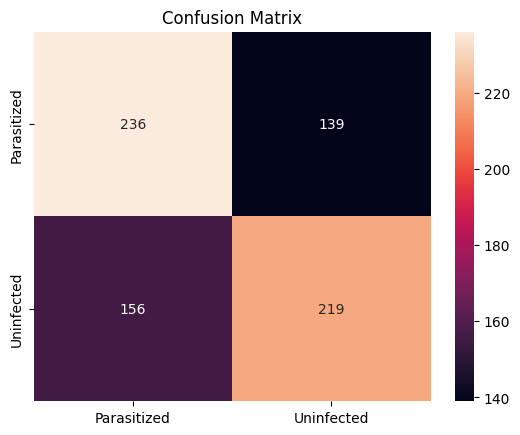

In [11]:
import seaborn as sns
#Evaluate on test set
all_preds, all_labels = [], []
model.eval()

start_time = time.time()  # total inference time

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        t0 = time.time()
        outputs = model(imgs)
        batch_time = time.time() - t0
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())

total_test_time = time.time() - start_time
avg_time = total_test_time / len(test_loader.dataset)

print(f"\nTotal Test Time: {total_test_time:.4f} sec")
print(f"Avg Inference Time: {avg_time:.6f} sec/image ({1/avg_time:.2f} FPS)")

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='binary', pos_label=class_to_idx['Parasitized']
)

print(f"Accuracy: {acc*100:.2f}%  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=list(class_to_idx.keys()),
            yticklabels=list(class_to_idx.keys()))
plt.title("Confusion Matrix")
plt.show()

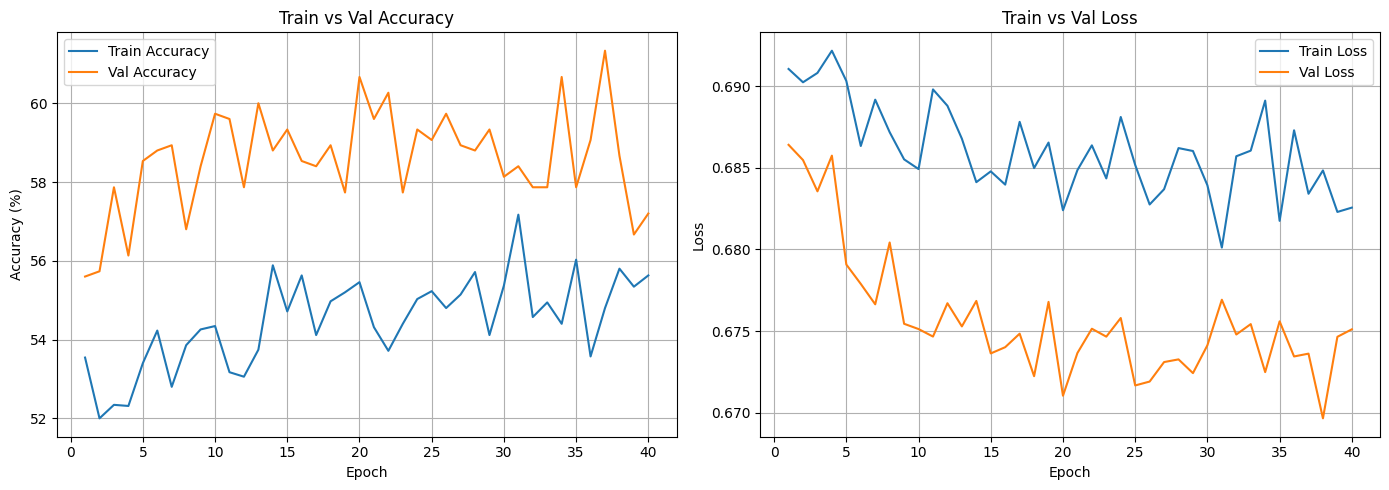

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# ------------------- Accuracy Plot -------------------
axs[0].plot(range(1, NUM_EPOCHS+1), [a*100 for a in train_accs], label="Train Accuracy")
axs[0].plot(range(1, NUM_EPOCHS+1), [a*100 for a in val_accs], label="Val Accuracy")
axs[0].set_title("Train vs Val Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[0].legend()
axs[0].grid(True)

# ------------------- Loss Plot -------------------
axs[1].plot(range(1, NUM_EPOCHS+1), train_losses, label="Train Loss")
axs[1].plot(range(1, NUM_EPOCHS+1), val_losses, label="Val Loss")
axs[1].set_title("Train vs Val Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()